In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.decomposition import NMF

np.random.seed(42)
np.set_printoptions(precision=3)

In [2]:
def plot_separate_H(H, img_size, figsize, fontsize, num_rows=4, normalize_row=False, filename=None):
    rank = H.shape[0]
    if normalize_row:
        H /= np.linalg.norm(H, axis=1, keepdims=True)
    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')
    num_cols = int(np.ceil(rank / num_rows))
    if num_rows > 1:
        fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
        cnt = 0
        for i in range(num_rows):
            for j in range(num_cols):
                if cnt < rank:
                    img = axs[i, j].imshow(H3d[cnt, :, :], cmap='gray')
                    axs[i, j].set_title(f'$h^{{{cnt + 1}}}$', fontsize=fontsize)
                    axs[i, j].axis('off')
                    divider = make_axes_locatable(axs[i, j])
                    cax = divider.append_axes('right', size='5%', pad=0.1)
                    fig.colorbar(img, cax=cax, orientation='vertical')
                else:
                    axs[i, j].axis('off')
                cnt += 1
    else:
        fig, axs = plt.subplots(1, rank, figsize=figsize)
        cnt = 0
        while cnt < rank:
            img = axs[cnt].imshow(H3d[cnt, :, :], cmap='gray')
            axs[cnt].set_title(f'$h^{{{cnt + 1}}}$', fontsize=fontsize)
            axs[cnt].axis('off')
            divider = make_axes_locatable(axs[cnt])
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(img, cax=cax, orientation='vertical')

            cnt += 1
    plt.tight_layout()
    if filename:
        plt.savefig(filename)
        plt.close()

def plot_combined_H(H, img_size, figsize, num_rows=1, normalize_row=False, filename=None):
    if normalize_row:
        H /= np.linalg.norm(H, axis=1, keepdims=True)

    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')

    if num_rows > 1:
        num_cols = int(np.ceil(H.shape[0] / num_rows))
        large_mat = np.vstack([np.hstack(H3d[i * num_cols: (i+1) * num_cols]) for i in range(num_rows)])
    else:
        large_mat = np.hstack(H3d)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(large_mat, cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')

    plt.tight_layout()

    if filename:
        plt.savefig(filename)
        plt.close()

def plot_W_mats(W, figsize, fontsize, n_rows=1, filename=None, scale_y=False, plot_title=None):
    rank = W.shape[1]
    wmin, wmax = np.min(W), np.max(W)

    n_cols = int(np.ceil(rank / n_rows))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    axs = axs.ravel()

    for cnt, ax in enumerate(axs):
        if cnt < rank:
            ax.plot(W[:, cnt], linewidth=3)
            if scale_y:
                ax.set_ylim([min(0, wmin), wmax])

            ax.set_title(f'$w_{{{cnt + 1}}}$', fontsize=fontsize)
            ax.set_xlabel('Bands')
            ax.set_ylabel('Reflectance')
        else:
            ax.axis('off')

    plt.tight_layout()
    if plot_title:
        fig.suptitle(plot_title, fontsize=25)
    if filename:
        fig.savefig(filename)
        plt.close()

def merge_images(images_list, filename, delete_images=False):
    imgs = [Image.open(i) for i in images_list]
    min_img_width = min(i.width for i in imgs)

    total_height = 0
    for i, img in enumerate(imgs):
        if img.width > min_img_width:
            imgs[i] = img.resize((min_img_width, int(img.height / img.width * min_img_width)), Image.ANTIALIAS)
        total_height += imgs[i].height

    img_merge = Image.new(imgs[0].mode, (min_img_width, total_height))
    y = 0
    for img in imgs:
        img_merge.paste(img, (0, y))
        y += img.height

    img_merge.save(filename)

    if delete_images:
        for fp in images_list:
            os.remove(fp)

def plot_and_merge(W, H, imgsize, figsize, fontsize, filenames, num_rows, delete=False):
    plot_W_mats(W, figsize, fontsize=fontsize, n_rows=num_rows, filename=filenames[0])
    plot_separate_H(H, imgsize, figsize=figsize, fontsize=fontsize, num_rows=num_rows, filename=filenames[1])
    plot_combined_H(H, imgsize, figsize=figsize, num_rows=num_rows, filename=filenames[2])
    merge_images(filenames[:3], filenames[3], delete_images=delete)

def load_results(filepath):
    data = np.load(filepath)
    return data['W'], data['H'], data['fscores'], data['gscores'], data['hscores'], data['total_scores']

## Region selection (for Jasper subimages)

In [ ]:
img = plt.imread('../for_article/jasper_image.png')
plt.imshow(img)

rect1 = patches.Rectangle((0, 62), 8, 8, linewidth=2, edgecolor='r', facecolor='none') # jasper region 1
rect2 = patches.Rectangle((30, 10), 10, 10, linewidth=2, edgecolor='r', facecolor='none') # jasper region 2
rect3 = patches.Rectangle((0, 0), 99, 99, linewidth=2, edgecolor='r', facecolor='none')

ax = plt.gca()
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

ax.text(-4, 67, "1", color='r', fontsize=30, ha='center', va='center')
ax.text(35, 16, "2", color='r', fontsize=30, ha='center', va='center')
ax.text(106, 98, "3", color='r', fontsize=30, ha='right', va='bottom')

ax.axis(False)
plt.savefig('../for_article/jasper_regions.pdf', bbox_inches='tight')

In [ ]:

img = plt.imread('../for_article/urban.png')
plt.imshow(img)
plt.axis(False)
plt.savefig('../for_article/urban.pdf', bbox_inches='tight')

## Synthetic

In [ ]:
def plot_3d(ax, X, Wt, W):
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[0, :], X[1, :], X[2, :], c='lightblue', marker='o')
    ax.scatter(Wt[0, :], Wt[1, :], Wt[2, :], c='red', marker='o', s=144)
    ax.scatter(W[0, :], W[1, :], W[2, :], c='black', marker='x', s=144)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    # ax.legend(['Data points', 'True W', 'Estimated W'])
    ax.grid(True)

In [ ]:
data_filepath = '../datasets/synthetic_data.npz'

data = np.load(data_filepath)
M = data['M']
W_true = data['W_true']
H_true = data['H_true']

In [ ]:
row_labels = ['Rank 4', 'Rank 8']
col_labels = ['Vanilla NMF', 'Vanilla NMF (L2 norm adjusted)', 'SONNMF']

fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, len(col_labels) + 1, width_ratios=[0.02] + len(col_labels) * [1], hspace=0.1)

for i, rlabel in enumerate(row_labels):
    txt_ax = fig.add_subplot(gs[i, 0])
    txt_ax.text(0.5, 0.5, rlabel, ha='center', va='center', fontsize=14)
    txt_ax.axis('off')

r = 4
_lam = 1e-6
_gamma = 10
max_iters = 1000


vW1 = np.load('../saved_models/synthetic/vanilla_r{}_it{}.npz'.format(r, max_iters))['W']
col_norm_vW1 = np.linalg.norm(vW1, axis=0, ord=2, keepdims=True)
vW1_re = vW1 / col_norm_vW1
cW1, _, _, _, _, _ = load_results('../saved_models/synthetic/r{}_l{}_g{}_it{}.npz'.format(r, _lam, _gamma, max_iters))

for i, curr_W in enumerate([vW1, vW1_re, cW1]):
    curr_subplot = fig.add_subplot(gs[0, i+1], projection='3d')
    plot_3d(curr_subplot, M, W_true, curr_W)
    curr_subplot.set_title(col_labels[i], fontsize=14)


r = 8
_lam = 1e-6
_gamma = 1.5

vW2 = np.load('../saved_models/synthetic/vanilla_r{}_it{}.npz'.format(r, max_iters))['W']
col_norm_vW2 = np.linalg.norm(vW2, axis=0, ord=2, keepdims=True)
vW2_re = vW2 / col_norm_vW2
cW2, _, _, _, _, _ = load_results('../saved_models/synthetic/r{}_l{}_g{}_it{}.npz'.format(r, _lam, _gamma, max_iters))

for i, curr_W in enumerate([vW2, vW2_re, cW2]):
    plot_3d(fig.add_subplot(gs[1, i+1], projection='3d'), M, W_true, curr_W)
fig.legend(['Data points', 'True W', 'Estimated W'],
                 bbox_to_anchor=(0.2, 0.9, 0, 0))
fig.subplots_adjust(wspace=0)
plt.savefig('../for_article/synthetic_vanilla_vs_sonnmf.pdf', bbox_inches='tight')

In [ ]:
ini_filepath = '../saved_models/synthetic/r{}_ini.npz'
save_filepath = '../saved_models/synthetic/r{}_l{}_g{}_it{}.npz'

r = 8
_lam = 1e-6
_gamma = 1.5

fig = plt.figure(figsize=(16, 5))
axs = [fig.add_subplot(1, 4, i+1, projection='3d') for i in range(4)]


data = np.load(ini_filepath.format(r))
ini_W = data['ini_W']
ini_H = data['ini_H']
plot_3d(axs[0], M, W_true, ini_W)
axs[0].set_title('Initial')


# Loop over iterations and plot W using plot_3d function
for i, it in enumerate([10, 100, 1000]):
    W, _, _, _, _, _ = load_results(save_filepath.format(r, _lam, _gamma, it))
    plot_3d(axs[i+1], M, W_true, W)
    axs[i+1].set_title('{} iterations'.format(it))
fig.legend(['Data points', 'True W', 'Estimated W'],
                 bbox_to_anchor=(0.97, 0.85, 0, 0))
# plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.2)

plt.savefig('../for_article/synthetic_r8_iterations.pdf', bbox_inches='tight')

## jasper region 1 (8x8)

In [3]:
r = 64
_lam = 40000
_gamma = 10000
max_iters = 2000

W, H, fscores, gscores, hscores, total_scores = load_results(f'../saved_models/jasper_region_1/r{r}_l{_lam}_g{_gamma}_it{max_iters}.npz')

In [4]:
# plt.imshow(np.corrcoef(W, rowvar=False), 'gray')
# plt.colorbar()
# plt.tight_layout()

In [5]:
unique_idxs = [17]
other_idxs = [x for x in range(r) if x not in unique_idxs]

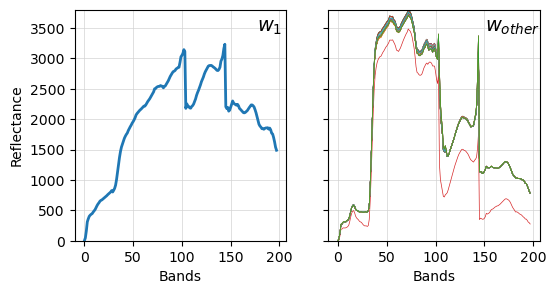

In [6]:
wmin, wmax = np.min(W), np.max(W)


fig, axs = plt.subplots(1, len(unique_idxs) + 1, figsize=(6, 3), sharex=True, sharey=True)
axs = axs.ravel()


for cnt, ax in enumerate(axs):
    if cnt == 0:
        ax.set_ylabel('Reflectance')
    ax.set_xlabel('Bands')
    ax.set_ylim([min(0, wmin), wmax])
    ax.grid(which='both', linewidth=0.5, color='lightgrey')


for ax_idx, w_idx in enumerate(unique_idxs):
    axs[ax_idx].plot(W[:, w_idx], linewidth=2)
    axs[ax_idx].set_title(f'$w_{{{w_idx + 1}}}$', fontsize=14, x=0.92, y=0.87) # indexing from 1

axs[-1].plot(W[:, other_idxs], linewidth=0.5)
axs[-1].set_title('$w_{{{other}}}$', fontsize=14, x=0.87, y=0.87)

plt.savefig('../for_article/jasper_region_1_w_overlapped.pdf', bbox_inches='tight')

In [ ]:
newH = np.vstack((H[unique_idxs, :], H[other_idxs, :].sum(axis=0)))
newH3d = newH.reshape(-1, 8, 8, order='F')
large_mat = np.hstack(newH3d)

fig, ax = plt.subplots(figsize=(6, 3))
img = ax.imshow(large_mat, cmap='gray')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)
fig.colorbar(img, cax=cax, orientation='vertical')
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('../for_article/jasper_region_1_h_summed.pdf', bbox_inches='tight')

## jasper region 2 (10x10)

In [7]:
data_filepath = '../datasets/jasper_region_2.npz'
ini_filepath = '../saved_models/jasper_region_2/r{}_ini.npz'

In [8]:
M = np.load(data_filepath)['X']
M = M.astype(np.float64)
m, n = M.shape
r = n

In [9]:
if os.path.exists(ini_filepath.format(r)):
    data = np.load(ini_filepath.format(r))
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [10]:
_lam = 1000
_gamma = 0.001
max_iters = 1000

W, H, fscores, gscores, hscores, total_scores = load_results(f'../saved_models/jasper_region_2/r{r}_l{_lam}_g{_gamma}_it{max_iters}.npz')

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3), sharex=True, sharey=True)
axs = axs.ravel()

for cnt, ax in enumerate(axs):
    if cnt == 0:
        ax.set_ylabel('Reflectance')
    ax.set_xlabel('Bands')
    ax.grid(which='both', linewidth=0.5, color='lightgrey')


axs[0].plot(W / np.max(W), linewidth=0.5)
axs[0].set_title('SONNMF', fontsize=18, x=0.5, y=0.87)

w, v = np.linalg.eig(M @ M.T)
axs[1].plot(v[:, 0] / np.max(v[:, 0]), linewidth=1)
axs[1].set_title('Eigendecomposition', fontsize=12, x=0.5, y=0.87)


model = NMF(n_components=1, random_state=42, max_iter=max_iters)
W_NMF = model.fit_transform(X=M)
axs[2].plot(W_NMF / np.max(W_NMF), linewidth=1)
axs[2].set_title('NMF-1', fontsize=18, x=0.5, y=0.87)

axs[3].plot(W / np.max(W), linewidth=0.5)
axs[3].plot(v[:, 0] / np.max(v[:, 0]), linewidth=1)
axs[3].plot(W_NMF / np.max(W_NMF), linewidth=1)
axs[3].set_title('Overlapping', fontsize=12, x=0.5, y=0.87)


# Adjust layout and display plot
plt.tight_layout()
plt.savefig('../for_article/jasper_region_2_w_comp.pdf',)

## jasper full (100x100)

In [11]:
data_filepath = '../datasets/jasper_full.npz'
ini_filepath = '../saved_models/jasper_full/r{}_ini.npz'

In [12]:
M = np.load(data_filepath)['X']
M = M.astype(np.float64)
m, n = M.shape

r = 20
_lam = 1000000
_gamma = 1000000
max_iters = 1000

In [13]:
ini_filepath = '../saved_models/jasper_full/r{}_ini.npz'
if os.path.exists(ini_filepath.format(r)):
    data = np.load(ini_filepath.format(r))
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [14]:
W, H, fscores, gscores, hscores, total_scores = load_results(f'../saved_models/jasper_full/r{r}_l{_lam}_g{_gamma}_it{max_iters}.npz')

In [15]:
unique_idxs = [6, 8, 14]
other_idxs = [x for x in range(r) if x not in unique_idxs]

In [ ]:
# Energy calculations (%)
unique_labels = ['water', 'tree', 'soil']
for i in range(len(unique_idxs)):
    print(unique_labels[i], (np.linalg.norm(W[:, unique_idxs[i]:unique_idxs[i]+1] @ H[unique_idxs[i]:unique_idxs[i]+1, :], 'fro') / np.linalg.norm(M, 'fro')) * 100)

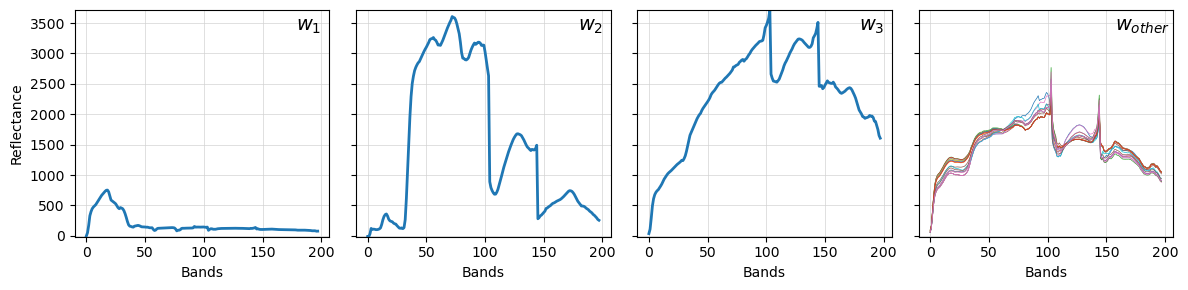

In [16]:
wmin, wmax = np.min(W), np.max(W)


fig, axs = plt.subplots(1, len(unique_idxs) + 1, figsize=(12, 3), sharex=True, sharey=True)
axs = axs.ravel()


for cnt, ax in enumerate(axs):
    if cnt == 0:
        ax.set_ylabel('Reflectance')
    ax.set_xlabel('Bands')
    ax.set_ylim([min(0, wmin), wmax])
    ax.grid(which='both', linewidth=0.5, color='lightgrey')


for ax_idx, w_idx in enumerate(unique_idxs):
    axs[ax_idx].plot(W[:, w_idx], linewidth=2)
    axs[ax_idx].set_title(f'$w_{{{w_idx + 1}}}$', fontsize=14, x=0.92, y=0.87) # indexing from 1

axs[-1].plot(W[:, other_idxs], linewidth=0.5)
axs[-1].set_title('$w_{{other}}}$', fontsize=14, x=0.88, y=0.87)

plt.tight_layout()
plt.savefig('../for_article/jasper_full_w_overlapped.pdf')

In [ ]:
newH = np.vstack((H[unique_idxs, :], H[other_idxs, :].sum(axis=0)))
newH3d = newH.reshape(-1, 100, 100, order='F')
large_mat = np.hstack(newH3d)

fig, ax = plt.subplots(figsize=(12, 3))
img = ax.imshow(large_mat, cmap='gray')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)
fig.colorbar(img, cax=cax, orientation='vertical')
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('../for_article/jasper_full_h_summed.pdf', bbox_inches='tight')

In [ ]:
# model = NMF(init='custom', n_components=r, random_state=42, max_iter=max_iters)
# W_NMF = model.fit_transform(X=M, W=ini_W.copy(), H=ini_H.copy())
# H_NMF = model.components_
# with open(f'../saved_models/jasper_full/vanilla_r{r}.npz', 'wb') as fout:
#     np.savez_compressed(fout, W=W_NMF, H=H_NMF)

In [ ]:
data = np.load(f'../saved_models/jasper_full/vanilla_r{r}.npz')
W_NMF = data['W']
H_NMF = data['H']
fns = ['../images/tmp_w.jpg', '../images/tmp_seph.jpg', '../images/tmp_combh.jpg', '../for_article/jasper_vanilla.pdf']
plot_and_merge(W_NMF, H_NMF, (100, 100), (33, 6), 16, fns, 2, delete=True)


## urban full (307x307)

In [17]:
data_filepath = '../datasets/urban_full.npz'
ini_filepath = '../saved_models/urban_full/r{}_ini.npz'

In [18]:
M = np.load(data_filepath)['X']
M = M.astype(np.float64)
m, n = M.shape

r = 20
_lam = 1000000
_gamma = 1000000
max_iters = 1000

In [19]:
ini_filepath = '../saved_models/urban_full/r{}_ini.npz'
if os.path.exists(ini_filepath.format(r)):
    data = np.load(ini_filepath.format(r))
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [20]:
W, H, fscores, gscores, hscores, total_scores = load_results(f'../saved_models/urban_full/r{r}_l{_lam}_g{_gamma}_it{max_iters}.npz')

In [21]:
unique_idxs = [5, 7, 13, 15]
other_idxs = [x for x in range(r) if x not in unique_idxs]

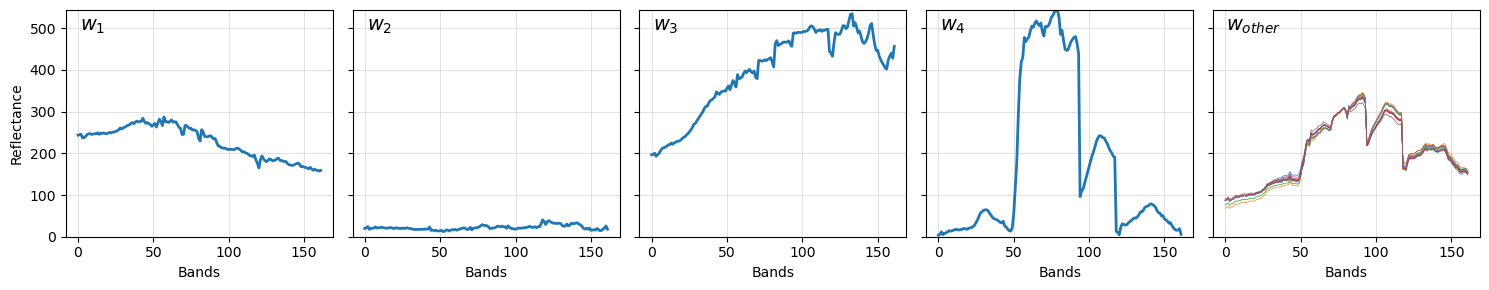

In [22]:
wmin, wmax = np.min(W), np.max(W)


fig, axs = plt.subplots(1, len(unique_idxs) + 1, figsize=(15, 3), sharex=True, sharey=True)
axs = axs.ravel()


for cnt, ax in enumerate(axs):
    if cnt == 0:
        ax.set_ylabel('Reflectance')
    ax.set_xlabel('Bands')
    ax.set_ylim([min(0, wmin), wmax])
    ax.grid(which='both', linewidth=0.5, color='lightgrey')


for ax_idx, w_idx in enumerate(unique_idxs):
    axs[ax_idx].plot(W[:, w_idx], linewidth=2)
    axs[ax_idx].set_title(f'$w_{{{w_idx + 1}}}$', fontsize=14, x=0.1, y=0.87) # indexing from 1

axs[-1].plot(W[:, other_idxs], linewidth=0.5)
axs[-1].set_title('$w_{{other}}$', fontsize=14, x=0.15, y=0.87)

plt.tight_layout()
plt.savefig('../for_article/urban_full_w_overlapped.pdf')

In [ ]:
newH = np.vstack((H[unique_idxs, :], H[other_idxs, :].sum(axis=0)))
newH3d = newH.reshape(-1, 307, 307, order='F')
large_mat = np.hstack(newH3d)

fig, ax = plt.subplots(figsize=(15, 3))
img = ax.imshow(large_mat, cmap='gray')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)
fig.colorbar(img, cax=cax, orientation='vertical')
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('../for_article/urban_full_h_summed.pdf', bbox_inches='tight')

In [ ]:
# model = NMF(init='custom', n_components=r, random_state=42, max_iter=max_iters)
# W_NMF = model.fit_transform(X=M, W=ini_W.copy(), H=ini_H.copy())
# H_NMF = model.components_
# with open(f'../saved_models/urban_full/vanilla_r{r}.npz', 'wb') as fout:
#     np.savez_compressed(fout, W=W_NMF, H=H_NMF)

In [ ]:
data = np.load(f'../saved_models/urban_full/vanilla_r{r}.npz')
W_NMF = data['W']
H_NMF = data['H']
fns = ['../images/tmp_w.jpg', '../images/tmp_seph.jpg', '../images/tmp_combh.jpg', '../for_article/urban_vanilla.pdf']
plot_and_merge(W_NMF, H_NMF, (307, 307), (33, 6), 16, fns, 2, delete=True)


## swimmer (256x220)

In [23]:
data_filepath = '../datasets/swimmer.npz'
ini_filepath = '../saved_models/swimmer/r{}_ini.npz'

In [24]:
M = np.load(data_filepath)['X']
M = M.astype(np.float64)
m, n = M.shape

r = 50
_lam = 0.5
_gamma = 10
max_iters = 1000

In [25]:
if os.path.exists(ini_filepath.format(r)):
    data = np.load(ini_filepath.format(r))
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath.format(r), 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [26]:
W, H, fscores, gscores, hscores, total_scores = load_results(f'../saved_models/swimmer/r{r}_l{_lam}_g{_gamma}_it{max_iters}.npz')

In [27]:
unique_idxs = [ 8,  0, 21, 33, 10, 44, 47, 12, 38, 16, 42, 18, 31, 17, 48, 14,  2]
# unique_idxs.sort()
other_idxs = [x for x in range(r) if x not in unique_idxs]


In [ ]:
wmin, wmax = np.min(W), np.max(W)

num_rows = 3
num_cols = len(unique_idxs) // num_rows + 1  # Calculate the number of columns needed
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 8), sharex=True, sharey=True)

axs = axs.ravel()

for cnt, ax in enumerate(axs):
    if cnt == 0 or cnt == num_cols:
        ax.set_ylabel('Reflectance')
    ax.set_xlabel('Bands')
    ax.set_ylim([min(0, wmin), wmax])
    ax.grid(which='both', linewidth=0.5, color='lightgrey')

for ax_idx, w_idx in enumerate(unique_idxs):
    row = ax_idx // num_cols 
    axs[ax_idx].plot(W[:, w_idx], linewidth=2)
    axs[ax_idx].set_title(f'$w_{{{w_idx + 1}}}$', fontsize=14, x=0.1, y=0.87) # indexing from 1

axs[-1].plot(W[:, other_idxs], linewidth=0.5)
axs[-1].set_title('$w_{other}$', fontsize=14, x=0.15, y=0.87)

plt.tight_layout()
plt.savefig('../for_article/swimmer_full_w_overlapped.pdf')

In [ ]:
num_rows = 2
num_cols = len(unique_idxs) // num_rows + 1 
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5))

H3d = H.reshape(-1, 20, 11, order='F')

axs = axs.ravel()

for ax_idx, w_idx in enumerate(unique_idxs):
    row = ax_idx // num_cols  
    img = axs[ax_idx].imshow(H3d[w_idx, :, :], cmap='gray')
    # img = axs[ax_idx].imshow(H3d[w_idx, :, :])
    axs[ax_idx].set_title(f'$h^{{{w_idx + 1}}}$', fontsize=14) # indexing from 1

    divider = make_axes_locatable(axs[ax_idx])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(img, cax=cax, orientation='vertical')
    axs[ax_idx].axis('off')
    
    

img = axs[-1].imshow(H3d[other_idxs, :, :].sum(axis=0), cmap='gray')
# img = axs[-1].imshow(H3d[other_idxs, :, :].sum(axis=0))
axs[-1].set_title('$h^{other}$', fontsize=14)
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(img, cax=cax, orientation='vertical')
axs[-1].set_xticks([])
axs[-1].set_yticks([])

# plt.tight_layout()
plt.savefig('../for_article/swimmer_full_h_summed.pdf', bbox_inches='tight')

In [ ]:
# model = NMF(init='custom', n_components=r, random_state=42, max_iter=max_iters)
# W_NMF = model.fit_transform(X=M, W=ini_W.copy(), H=ini_H.copy())
# H_NMF = model.components_
# with open(f'../saved_models/swimmer/vanilla_r{r}.npz', 'wb') as fout:
#     np.savez_compressed(fout, W=W_NMF, H=H_NMF)

In [30]:
data = np.load(f'../saved_models/swimmer/vanilla_r{r}.npz')
W_NMF = data['W']
H_NMF = data['H']
fns = ['../images/tmp_w.jpg', '../images/tmp_seph.jpg', '../images/tmp_combh.jpg', '../for_article/swimmer_vanilla.pdf']
plot_and_merge(W_NMF, H_NMF, (20, 11), (16, 10), 16, fns, 5, delete=True)


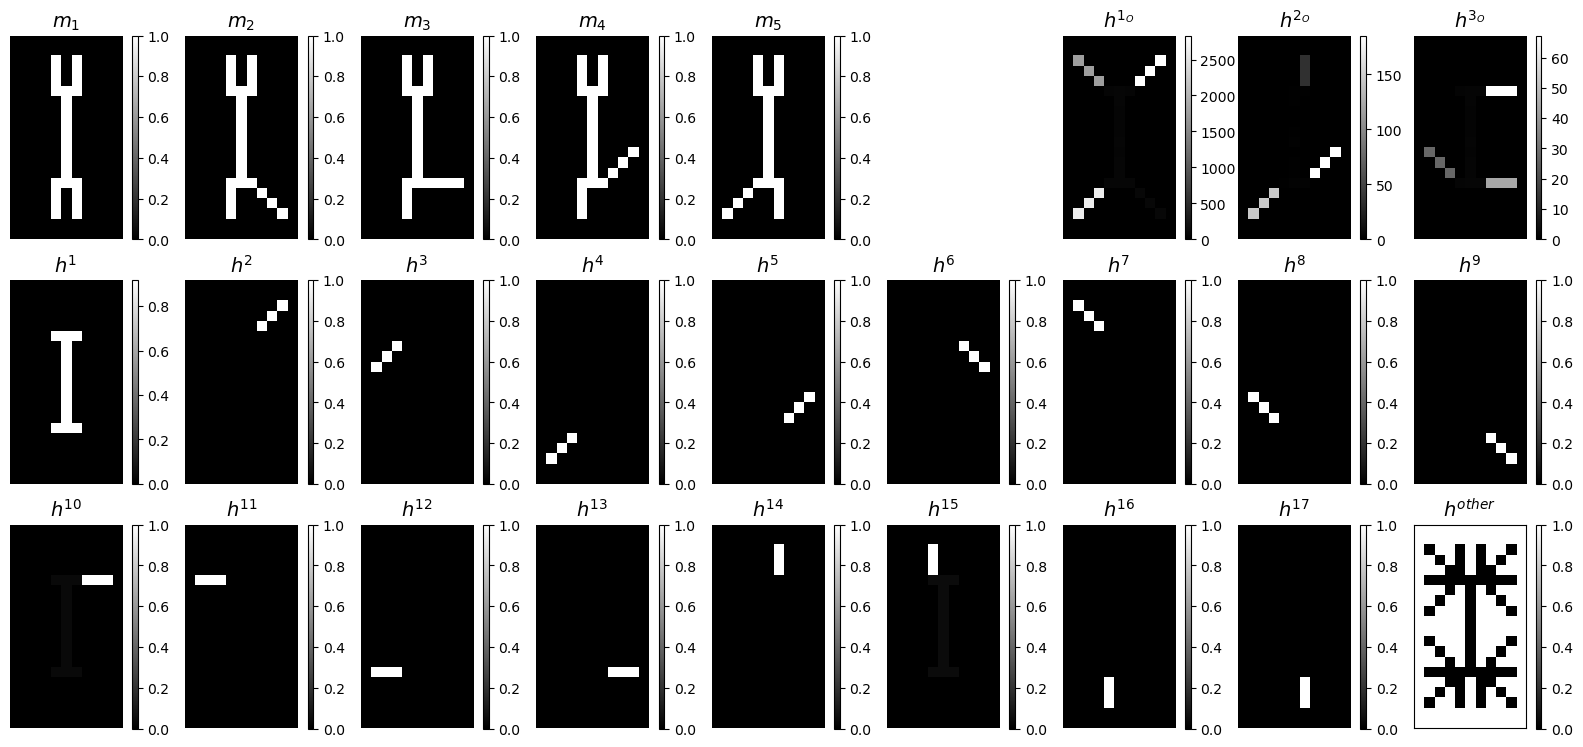

In [33]:
num_rows = 3
num_cols = 9
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 9))

M3d = M.reshape(-1, 20, 11, order='F')
H3d = H.reshape(-1, 20, 11, order='F')
H_NMF3d = H_NMF.reshape(-1, 20, 11, order='F')

axs = axs.ravel()

for ax_idx in range(5):
    img = axs[ax_idx].imshow(M3d[ax_idx, :, :], cmap='gray')
    axs[ax_idx].set_title(f'$m_{{{ax_idx + 1}}}$', fontsize=14) # indexing from 1

    divider = make_axes_locatable(axs[ax_idx])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(img, cax=cax, orientation='vertical')
    axs[ax_idx].axis('off')


axs[5].axis('off')

for ax_idx, w_idx in enumerate([28, 43, 44]):
    mod_ax_idx = ax_idx + 6

    img = axs[mod_ax_idx].imshow(H_NMF3d[w_idx, :, :], cmap='gray')
    # img = axs[ax_idx].imshow(H3d[w_idx, :, :])
    axs[mod_ax_idx].set_title(f'$h^{{{w_idx + 1}_O}}$', fontsize=14) # indexing from 1

    divider = make_axes_locatable(axs[mod_ax_idx])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(img, cax=cax, orientation='vertical')
    axs[mod_ax_idx].axis('off')


for ax_idx, w_idx in enumerate(unique_idxs):
    mod_ax_idx = ax_idx + 9

    img = axs[mod_ax_idx].imshow(H3d[w_idx, :, :], cmap='gray')
    # img = axs[ax_idx].imshow(H3d[w_idx, :, :])
    axs[mod_ax_idx].set_title(f'$h^{{{w_idx + 1}}}$', fontsize=14) # indexing from 1

    divider = make_axes_locatable(axs[mod_ax_idx])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(img, cax=cax, orientation='vertical')
    axs[mod_ax_idx].axis('off')
    
    

img = axs[-1].imshow(H3d[other_idxs, :, :].sum(axis=0), cmap='gray')
# img = axs[-1].imshow(H3d[other_idxs, :, :].sum(axis=0))
axs[-1].set_title('$h^{other}$', fontsize=14)
divider = make_axes_locatable(axs[-1])
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(img, cax=cax, orientation='vertical')
axs[-1].set_xticks([])
axs[-1].set_yticks([])

# plt.tight_layout()
plt.savefig('../for_article/swimmer_lrg.pdf', bbox_inches='tight')